Learning both Weight and Connections for Efficient Neural Networks, 15`NIPS
===
modified from https://github.com/jack-willturner/DeepCompression-PyTorch

## Settings

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import torchvision
import torchvision.transforms as transforms

import os
import json
import argparse
from models import *
from utils  import *
from tqdm   import tqdm

In [34]:
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
parser.add_argument('--model',      default='resnet9', help='VGG-16, ResNet-18, LeNet')
parser.add_argument('--data_loc',   default='../datasets/cifar', type=str)
parser.add_argument('--checkpoint', default='resnet9', type=str, help='Pretrained model to start from')
parser.add_argument('--prune_checkpoint', default='', type=str, help='Where to save pruned models')
parser.add_argument('--GPU', default='0', type=str,help='GPU to use')
parser.add_argument('--save_every', default=5, type=int, help='How often to save checkpoints in number of prunes (e.g. 10 = every 10 prunes)')
parser.add_argument('--cutout', action='store_true')

### training specific args
parser.add_argument('--finetune_steps', default=100)
parser.add_argument('--lr',             default=0.001)
parser.add_argument('--weight_decay', default=0.0005, type=float)

args = parser.parse_args('')

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"]=args.GPU

## Dictionary of models to prune; 

### for practice, we're going to use ResNet9

In [36]:
models = {'resnet9'  : ResNet9(),
          'resnet18' : ResNet18(),
          'resnet34' : ResNet34(),
          'resnet50' : ResNet50(),
          'wrn_40_2' : WideResNet(40, 2),
          'wrn_16_2' : WideResNet(16, 2),
          'wrn_40_1' : WideResNet(40, 1)}

model = models[args.model]

### before moving on, let's take a look at the structure of ResNet

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Shortcut(nn.Module):
    def __init__(self, in_planes, planes, expansion=1, kernel_size=1, stride=1, bias=False, mode='train'):
        super(Shortcut, self).__init__()
        self.mode = mode
        self.conv1 = nn.Conv2d(in_planes, expansion*planes, kernel_size=kernel_size, stride=stride, bias=False)
        self.mask1 = nn.Conv2d(in_planes, expansion*planes, kernel_size=kernel_size, stride=stride, bias=False)
        self.mask1.weight.data = torch.ones(self.mask1.weight.size())
        self.bn1 = nn.BatchNorm2d(expansion*planes)

    def forward(self, x):
        self.conv1.weight.data = torch.mul(self.conv1.weight,  self.mask1.weight)
        return self.bn1(self.conv1(x))

    def __prune__(self, threshold):
        self.mode = 'prune'
        self.mask1.weight.data = torch.mul(torch.gt(torch.abs(self.conv1.weight), threshold).float(), self.mask1.weight)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, mode='train'):
        super(BasicBlock, self).__init__()
        self.mode  = mode
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mask1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.mask1.weight.data = torch.ones(self.mask1.weight.size())
        self.bn1   = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.mask2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.mask2.weight.data = torch.ones(self.mask2.weight.size())
        self.bn2   = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = Shortcut(in_planes, planes, self.expansion, kernel_size=1, stride=stride, bias=False)

    def forward(self, x):
        self.conv1.weight.data = torch.mul(self.conv1.weight,  self.mask1.weight)
        self.conv2.weight.data = torch.mul(self.conv2.weight,  self.mask2.weight)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

    def __prune__(self, threshold):
        self.mode = 'prune'
        self.mask1.weight.data = torch.mul(torch.gt(torch.abs(self.conv1.weight), threshold).float(), self.mask1.weight)
        self.mask2.weight.data = torch.mul(torch.gt(torch.abs(self.conv2.weight), threshold).float(), self.mask2.weight)

        if isinstance(self.shortcut, Shortcut):
            self.shortcut.__prune__(threshold)


### see how they create intial mask for every convlayer and when passing forward, it multiplies with the masks
<br>

### for __pruning__, note that torch.gt computes (first argument) > (second argument) in element-wise manner.
#### see for example :

In [6]:
torch.gt(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]]))

tensor([[False,  True],
        [False, False]])

### so, see how they make elements below threshold to be False, hence the multiplication would result in 0 --> masking!

In [37]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, mode='train'):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.mode = mode
        self.conv1  = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.mask1  = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.mask1.weight.data = torch.ones(self.mask1.weight.size())
        self.bn1    = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        self.conv1.weight.data = torch.mul(self.conv1.weight,  self.mask1.weight)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def __prune__(self, threshold):
        self.mode = 'prune'
        self.mask1.weight.data = torch.mul(torch.gt(torch.abs(self.conv1.weight), threshold).float(), self.mask1.weight)
        layers = [self.layer1, self.layer2, self.layer3, self.layer4]
        for layer in layers:
            for sub_block in layer:
                sub_block.__prune__(threshold)

In [38]:
def ResNet9():
    return ResNet(BasicBlock, [1,1,1,1])

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

In [39]:
# load the model
model, sd = load_model(model, args.checkpoint, old_format=False)

In [40]:
if args.prune_checkpoint == '':
    prune_checkpoint = args.checkpoint + '_l1_'
else:
    prune_checkpoint = args.prune_checkpoint

In [41]:
if torch.cuda.is_available():
    model = model.cuda()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (mask1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (mask1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (mask2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_

### For the datasets, we're going to use CIFAR 10

In [42]:
trainloader, testloader = get_cifar_loaders(args.data_loc, cutout=args.cutout)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


### Model primarily consists of masks for each layers to delete the pruned units; hence, we need if condition as below

In [43]:
optimizer = optim.SGD([w for name, w in model.named_parameters() if not 'mask' in name], lr=args.lr, momentum=0.9, weight_decay=args.weight_decay)

### above optimizer will be used in finetuning <br>
<br>

### for the learning rate in finetuning, the paper suggests to take much smaller value than for the previous training, therefore

In [44]:
# set the learning rate to be 1/8th of final LR
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 200, eta_min=1e-10)
for epoch in range(sd['epoch']):
    scheduler.step()
for group in optimizer.param_groups:
    group['lr'] = scheduler.get_lr()[0]

/home/jaeyeon/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:117: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


## defining functions:

### 1. functions for pruning

In [17]:
# recursive function; starting from the empty stack (layers = torch.Tensor()), it concatenate the model weight 

def expand_model(model, layers=torch.Tensor()):
    for layer in model.children():
         if len(list(layer.children())) > 0:
             layers = expand_model(layer, layers)
         else:
             if isinstance(layer, nn.Conv2d) and 'mask' not in layer._get_name():
                 layers = torch.cat((layers.view(-1), layer.weight.view(-1)))
    return layers

# the rest are intuitive

def calculate_threshold(model, rate):
    empty = torch.Tensor()
    if torch.cuda.is_available():
        empty = empty.cuda()
    pre_abs = expand_model(model, empty)
    weights = torch.abs(pre_abs)

    return np.percentile(weights.detach().cpu().numpy(), rate)

def sparsify(model, prune_rate=50.):
    threshold = calculate_threshold(model, prune_rate)
    try:
        model.__prune__(threshold)
    except:
        model.module.__prune__(threshold)
    return model

### 2. function for computing error

In [45]:
def get_error(output, target, topk=(1,)):
    """Computes the error@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True) # returning index of k classes with largest value for each input, sorted in order
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred)) # k * batch_size

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(100.0 - correct_k.mul_(100.0 / batch_size))
    return res

### 3. Modules for training, testing, and finetuning

In [46]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [47]:
def train(model, trainloader, criterion, optimizer):
    batch_time = AverageMeter()
    data_time  = AverageMeter()
    losses     = AverageMeter()
    top1       = AverageMeter()
    top5       = AverageMeter()

    # switch to train mode
    model.train()
    for i, (input, target) in enumerate(trainloader):
        input, target = input.to(device), target.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # measure accuracy and record loss
        err1, err5 = get_error(output.detach(), target, topk=(1, 5))

        losses.update(loss.item(), input.size(0))
        top1.update(err1.item(), input.size(0))
        top5.update(err5.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def validate(model, epoch, valloader, criterion, checkpoint=None):
    global error_history

    batch_time = AverageMeter()
    data_time = AverageMeter()

    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    for i, (input, target) in enumerate(valloader):
        input, target = input.to(device), target.to(device)
        # compute output
        output = model(input)
        loss = criterion(output, target)
        err1, err5 = get_error(output.detach(), target, topk=(1, 5))

        losses.update(loss.item(), input.size(0))
        top1.update(err1.item(), input.size(0))
        top5.update(err5.item(), input.size(0))

    error_history.append(top1.avg)
    if checkpoint:

        state = {
            'net': model.state_dict(),
            'masks': [w for name, w in model.named_parameters() if 'mask' in name],
            'epoch': epoch,
            'error_history': error_history,
        }
        torch.save(state, 'checkpoints/%s.t7' % checkpoint)

def finetune(model, trainloader, criterion, optimizer, steps=100):
    # switch to train mode
    model.train()
    dataiter = iter(trainloader)
    for i in range(steps):
        try:
            input, target = dataiter.next()
        except StopIteration:
            dataiter = iter(trainloader)
            input, target = dataiter.next()

        input, target = input.to(device), target.to(device)

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## Let's prune the pretrained model

In [21]:
for prune_rate in tqdm(range(100)):
    model = sparsify(model, prune_rate)

    if prune_rate % args.save_every == 0:
        checkpoint = prune_checkpoint + str(prune_rate)
    else:
        checkpoint = None # don't bother saving anything

    finetune(model, trainloader, criterion, optimizer, args.finetune_steps)

    if checkpoint:
        validate(model, prune_rate, testloader, criterion, checkpoint=checkpoint)

100%|██████████| 100/100 [06:39<00:00,  3.99s/it]


## Now let's see what we've got

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from models import *
plt.style.use('ggplot')
%matplotlib inline

In [23]:
# count only conv params for now
def get_no_params(net, verbose=False, mask=False):
    params = net
    tot = 0
    for p in params:
        no = torch.sum(params[p]!=0)
        if 'conv' in p:
            tot += no
    return tot

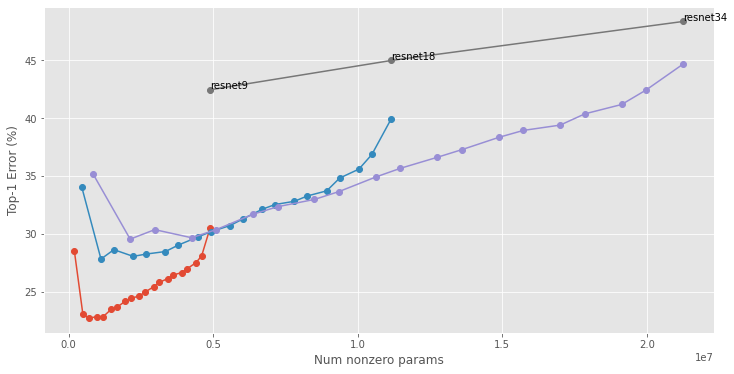

In [24]:
fig,ax      = plt.subplots(figsize=(12,6))
prune_rates = np.arange(0,100,step=5)
checkpoints = ['resnet9','resnet18','resnet34']

def get_nonzeros(sd):
    tot = 0
    for mask in sd['masks']:
        tot += torch.sum(mask!=0)
    return tot

for checkpoint in checkpoints:
    x = []
    y = []
    for prune_rate in prune_rates:
        sd = torch.load('checkpoints/%s.t7' % str(checkpoint + '_l1_' + str(prune_rate)), map_location='cpu')
        x.append(get_nonzeros(sd))
        y.append(sd['error_history'][-1])
    ax.plot(x,y,marker='o')

x = []
y = []

for checkpoint in checkpoints:
    sd = torch.load('checkpoints/%s.t7' % checkpoint, map_location='cpu')
    
    x_  = get_no_params(sd['net'])
    y_  = sd['error_history'][-1]
    x.append(x_)
    y.append(y_)
    
for i, net in enumerate(checkpoints):
    offset = 0.1
    ax.annotate(net, (x[i]+offset, y[i]+offset))    
ax.plot(x,y, marker='o')

ax.set_xlabel('Num nonzero params')
ax.set_ylabel('Top-1 Error (%)')
plt.show()
